In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

c:\Users\sanja\anaconda3\envs\object_detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
torch:  1.13 ; cuda:  1.13.1
detectron2: 0.6


In [2]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
		
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from PIL import Image
def show_image(im):
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

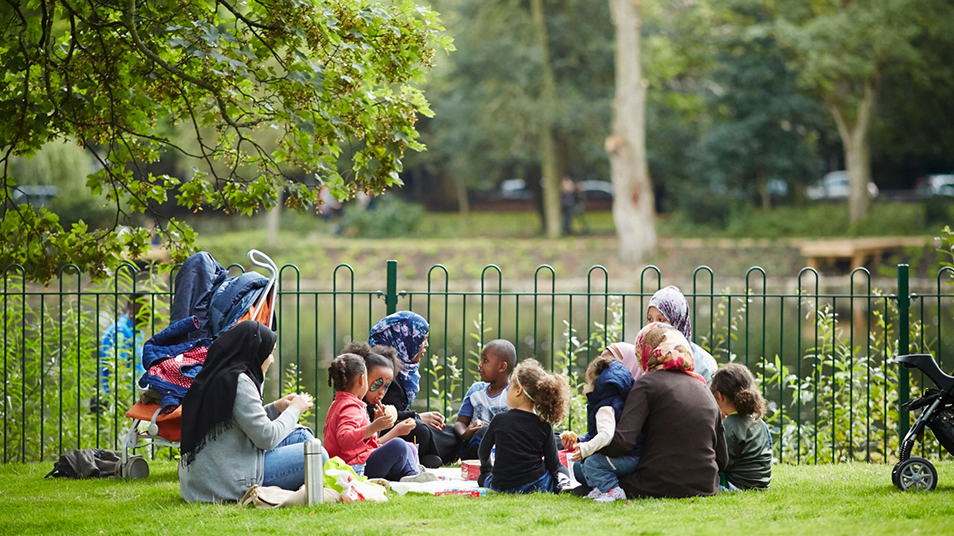

In [5]:
im = cv2.imread("park_img.jpeg")
show_image(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[03/29 23:10:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


c:\Users\sanja\anaconda3\envs\object_detect\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0, 24,  0,  0],
       device='cuda:0')
Boxes(tensor([[479.6354, 360.6107, 578.9101, 497.2187],
        [582.1481, 319.2708, 727.8579, 502.2781],
        [711.3279, 366.1620, 774.8680, 494.1295],
        [321.6210, 346.3465, 441.6799, 480.6606],
        [174.2038, 321.2292, 369.7740, 508.2989],
        [421.1278, 337.6936, 517.2186, 467.5465],
        [804.8328, 169.8857, 880.6626, 201.2412],
        [892.0585, 352.7545, 953.0394, 485.4956],
        [568.4149, 349.7349, 639.1891, 490.3507],
        [366.9258, 315.5603, 451.1907, 463.6997],
        [593.5890, 285.0244, 719.4207, 390.2257],
        [140.2962, 253.0584, 273.5828, 381.4100],
        [368.8953, 310.4024, 430.7653, 412.0453],
        [560.3398, 175.6844, 579.5269, 236.0890]], device='cuda:0'))


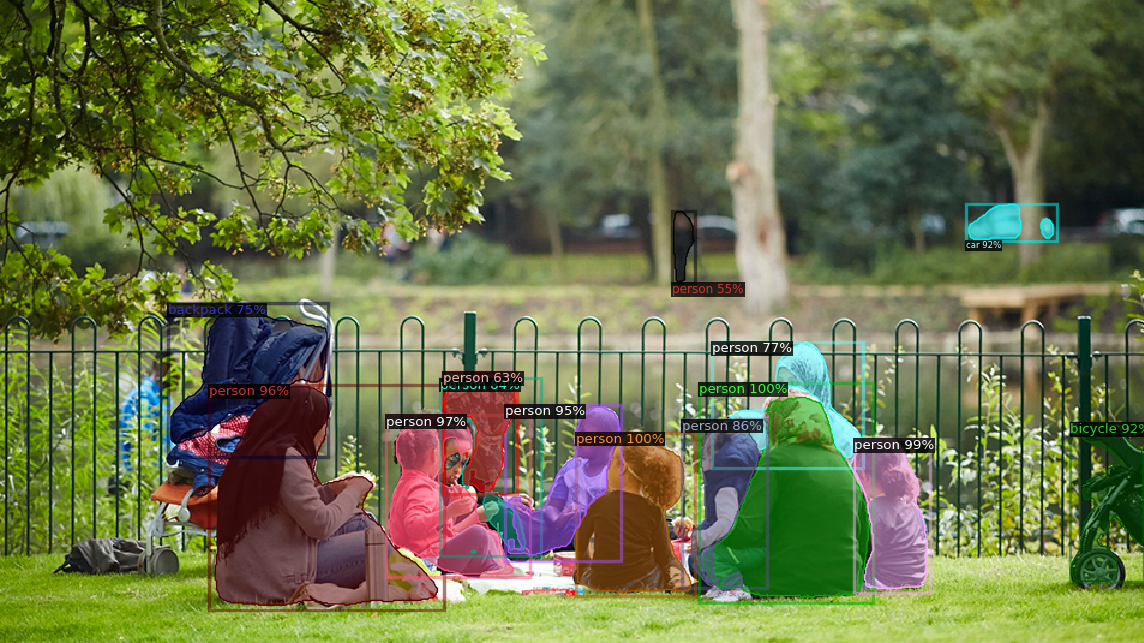

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])

[03/29 23:10:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


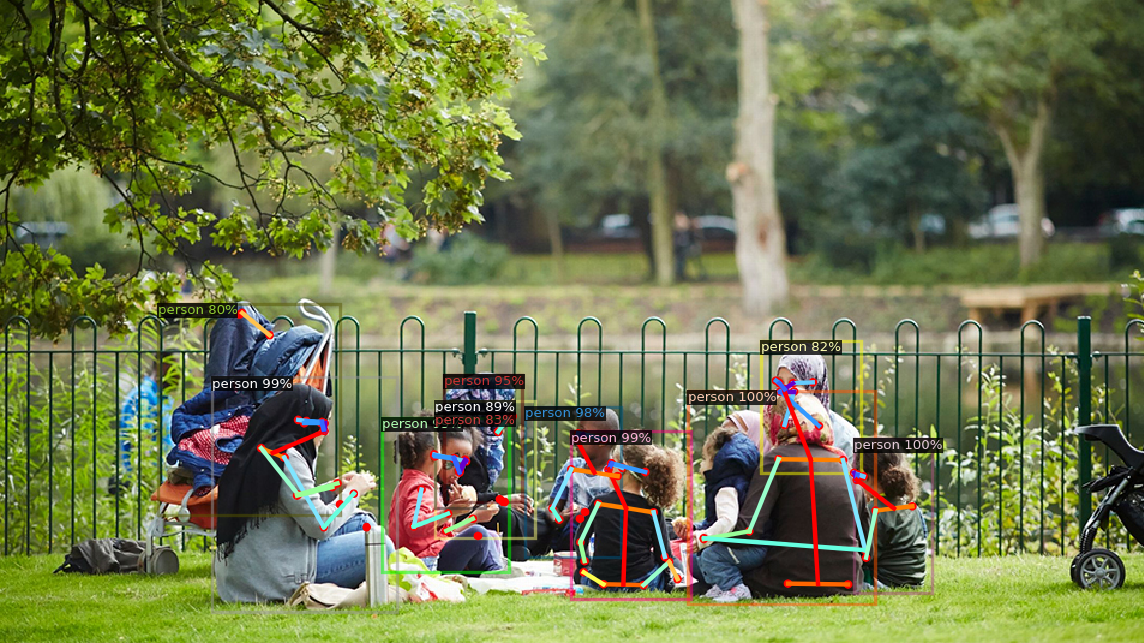

In [9]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])

[03/29 23:11:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


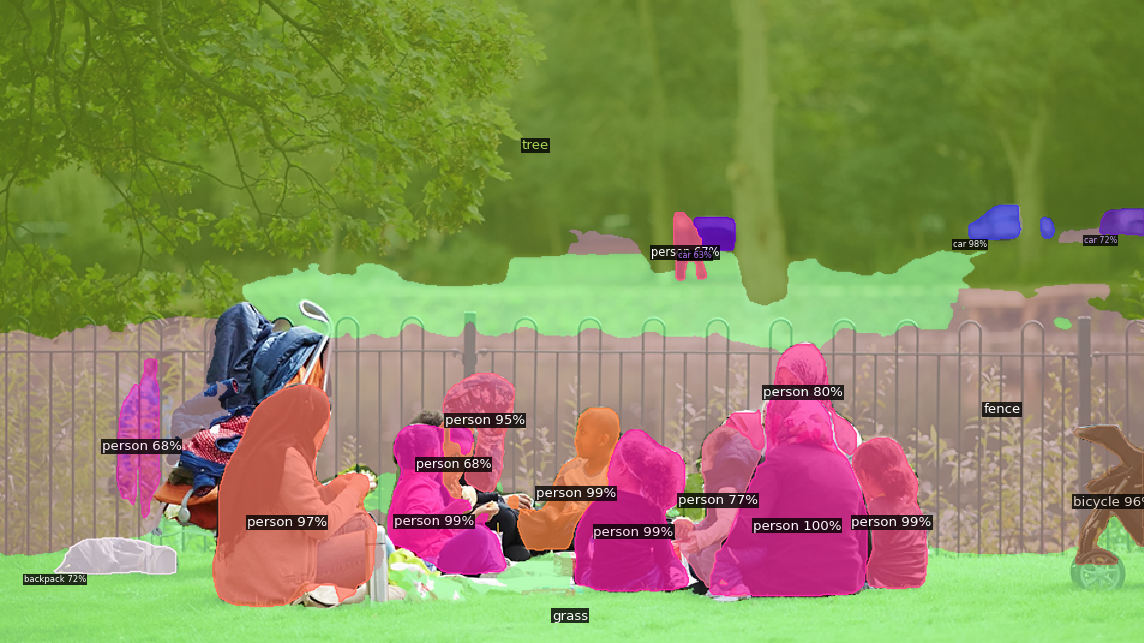

In [10]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
pred = predictor(im)
panoptic_seg, segments_info = pred["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
show_image(out.get_image()[:, :, ::-1])

In [11]:
from detectron2.structures import BitMasks

# Assuming `outputs` is the output of a panoptic segmentation model
panoptic_seg, segments_info = pred["panoptic_seg"]
panoptic_seg

tensor([[18, 18, 18,  ..., 18, 18, 18],
        [18, 18, 18,  ..., 18, 18, 18],
        [18, 18, 18,  ..., 18, 18, 18],
        ...,
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20]], device='cuda:0', dtype=torch.int32)

In [12]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.997917115688324,
  'category_id': 0,
  'instance_id': 0,
  'area': 15314.0},
 {'id': 2,
  'isthing': True,
  'score': 0.9938218593597412,
  'category_id': 0,
  'instance_id': 1,
  'area': 5600.0},
 {'id': 3,
  'isthing': True,
  'score': 0.9918184280395508,
  'category_id': 0,
  'instance_id': 2,
  'area': 7249.0},
 {'id': 4,
  'isthing': True,
  'score': 0.9905785918235779,
  'category_id': 0,
  'instance_id': 3,
  'area': 9181.0},
 {'id': 5,
  'isthing': True,
  'score': 0.9873539805412292,
  'category_id': 0,
  'instance_id': 4,
  'area': 4698.0},
 {'id': 6,
  'isthing': True,
  'score': 0.983364999294281,
  'category_id': 2,
  'instance_id': 5,
  'area': 1164.0},
 {'id': 7,
  'isthing': True,
  'score': 0.9708980917930603,
  'category_id': 0,
  'instance_id': 6,
  'area': 17801.0},
 {'id': 8,
  'isthing': True,
  'score': 0.9554339647293091,
  'category_id': 1,
  'instance_id': 7,
  'area': 3828.0},
 {'id': 9,
  'isthing': True,
  'score':

In [13]:
from PIL import Image

def get_masks(item_mask_index, pred):
    masks = np.asarray(pred['instances'].pred_masks.to("cpu"))
    item_mask = masks[item_mask_index]
    segmentation = np.where(item_mask == True)
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))
    return x_min, x_max, y_min, y_max, item_mask

def crop(im, x_min, x_max, y_min, y_max):
    cropped = Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')
    show_image(np.array(cropped))
    return cropped

def alpha_mask(cropped, background, cropped_mask, paste_position = (0, 300)):
    new_fg_image = Image.new('RGB', background.size)
    new_fg_image.paste(cropped, paste_position)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(cropped_mask, paste_position)
    show_image(np.array(new_fg_image))
    return new_fg_image, new_alpha_mask

def clone(item_mask_index, pred, im, paste_position = (0, 300)):
    x_min, x_max, y_min, y_max, item_mask = get_masks(item_mask_index, pred)
    cropped = crop(im, x_min, x_max, y_min, y_max)
    mask = Image.fromarray((item_mask * 255).astype('uint8'))

    cropped_mask = mask.crop((x_min, y_min, x_max, y_max))
    background = Image.fromarray(im, mode='RGB')
    new_fg_image, new_alpha_mask = alpha_mask(cropped, background, cropped_mask)

    composite = Image.composite(new_fg_image, background, new_alpha_mask)
    show_image(np.array(composite))

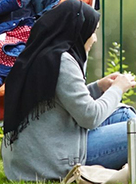

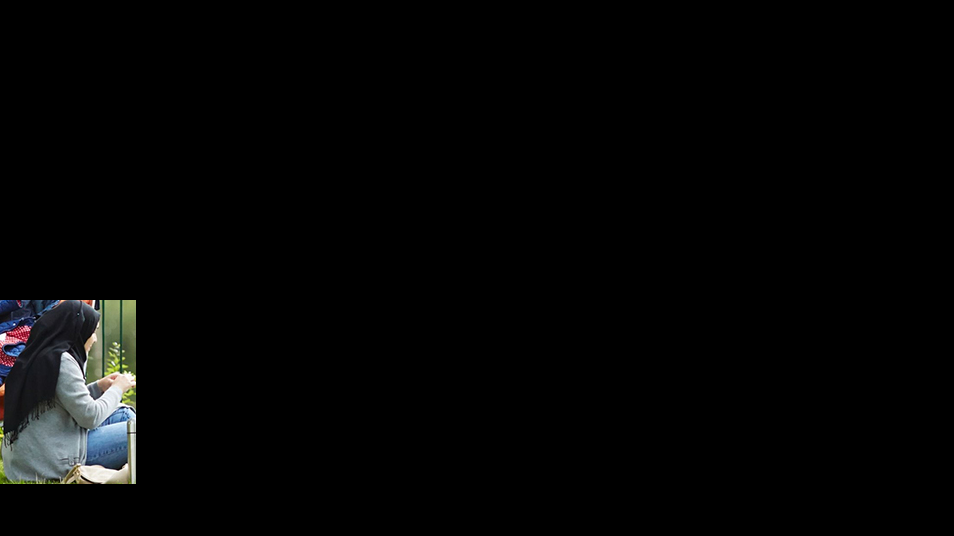

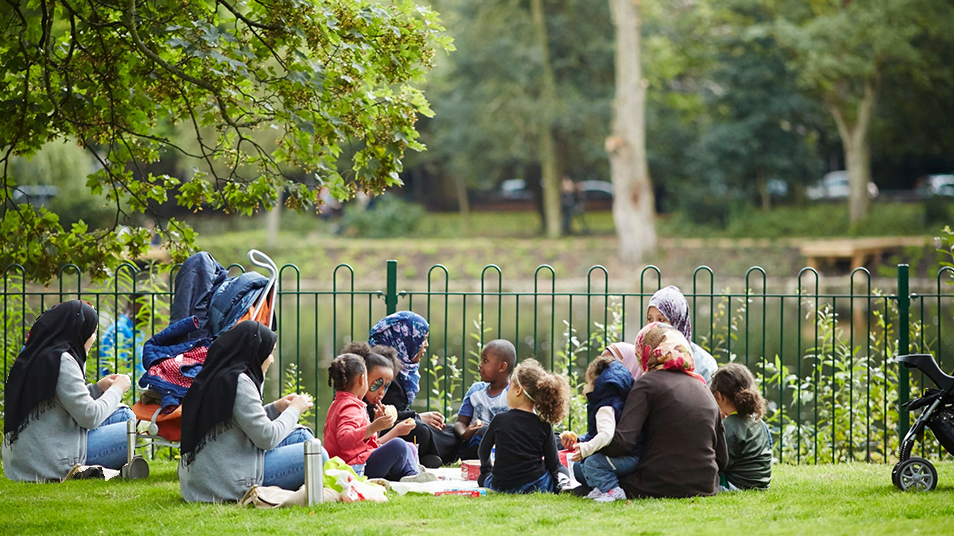

In [14]:
clone(6, pred, im)

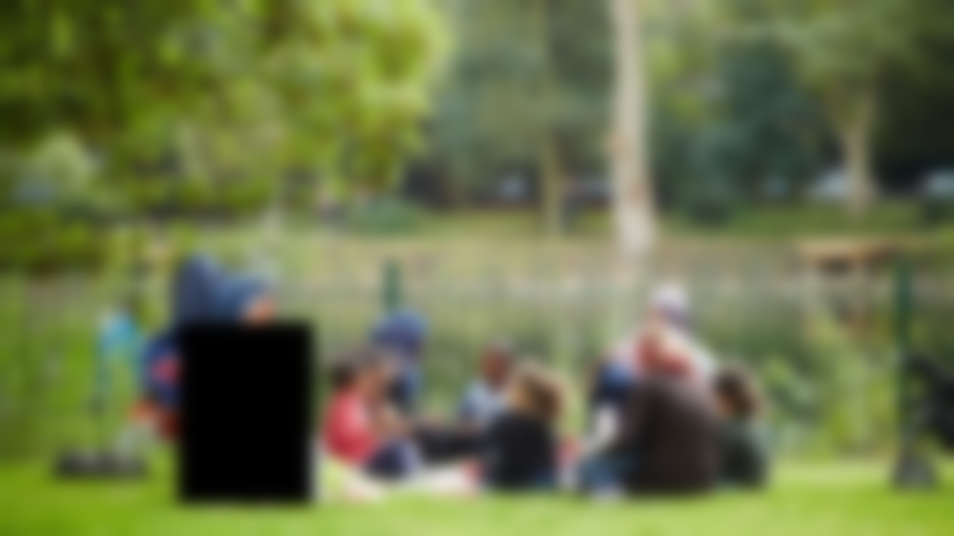

In [15]:
# Select the ROI using numpy indexing
x_min, x_max, y_min, y_max, item_mask = get_masks(6, pred)      
roi = im[y_min:y_max, x_min:x_max]

# Create a mask with the ROI area filled with zeros
mask = np.zeros(im.shape[:2], dtype=np.uint8)
mask[y_min:y_max, x_min:x_max] = 255

# Invert the mask to select the background
mask_inv = cv2.bitwise_not(mask)
bg = cv2.bitwise_and(im, im, mask=mask_inv)

# Apply a blur effect to the background
blurred_bg = cv2.GaussianBlur(bg, (51,51), 0)

show_image(blurred_bg)

In [16]:
blurred_bg[y_min:y_max, x_min:x_max] = roi

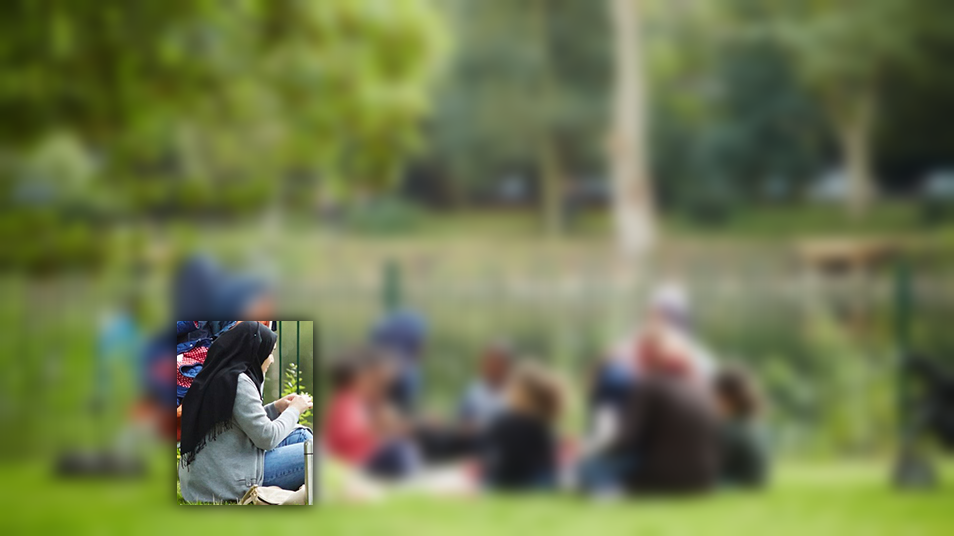

In [17]:
show_image(blurred_bg)

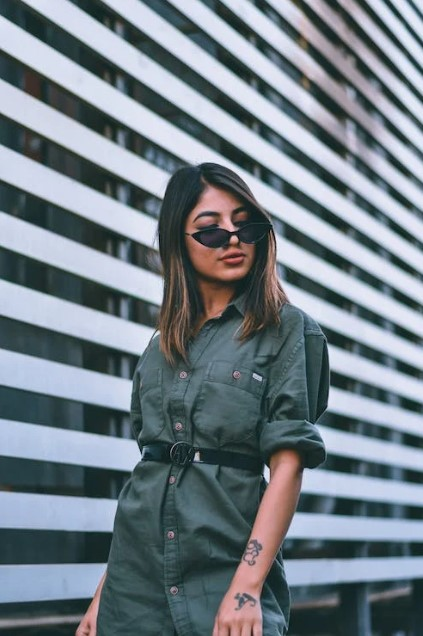

In [18]:
img = cv2.imread('posing.jpg')
show_image(img)

In [19]:
# Inference with a panoptic segmentation model
cfg_1 = get_cfg()
cfg_1.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_1.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor_1 = DefaultPredictor(cfg)
pred_1 = predictor(img)

[03/29 23:11:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


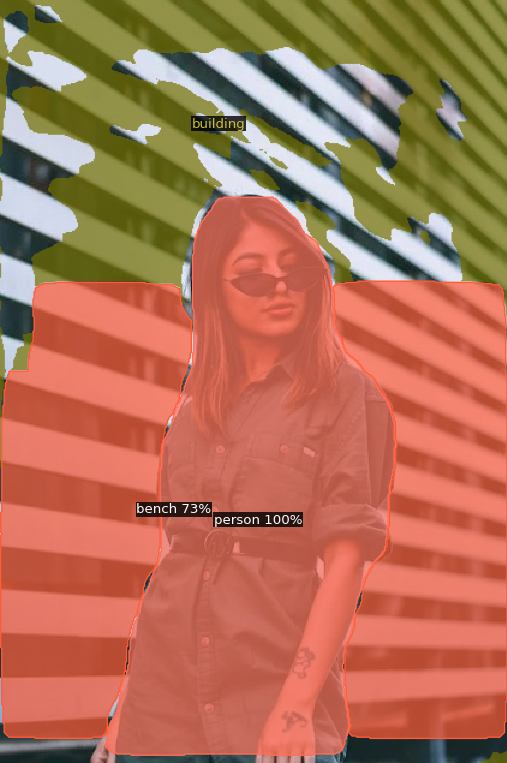

In [20]:
panoptic_seg, segments_info = pred_1["panoptic_seg"]
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
show_image(out.get_image()[:, :, ::-1])

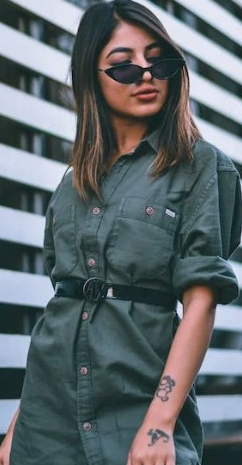

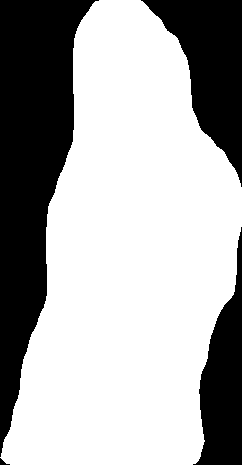

In [25]:
x_min, x_max, y_min, y_max, item_mask = get_masks(0, pred_1)
cropped = crop(img, x_min, x_max, y_min, y_max)
mask = Image.fromarray((item_mask * 255).astype('uint8'))
cropped_mask = mask.crop((x_min, y_min, x_max, y_max))
blurred_image = cv2.GaussianBlur(img, (21,21), 0)
show_image(np.array(cropped_mask))

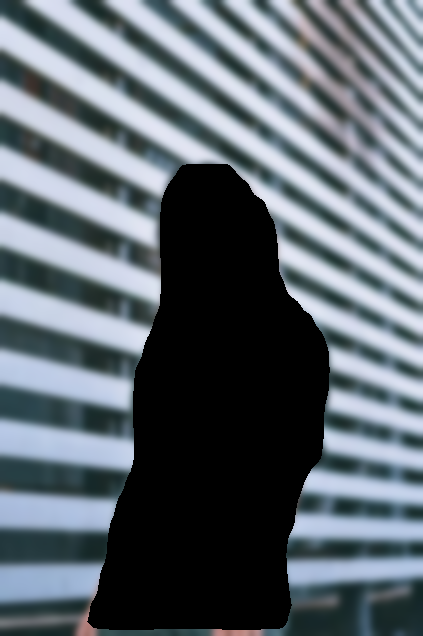

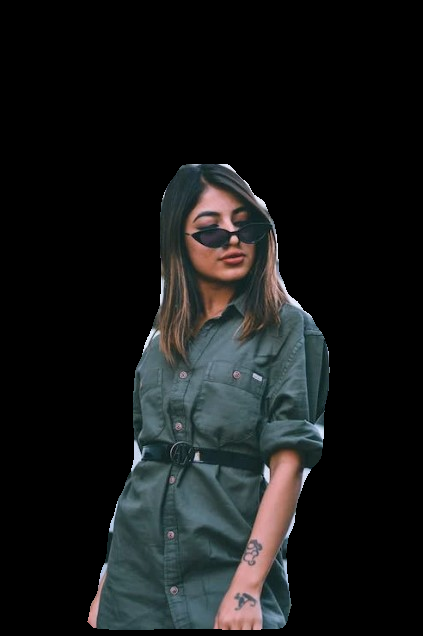

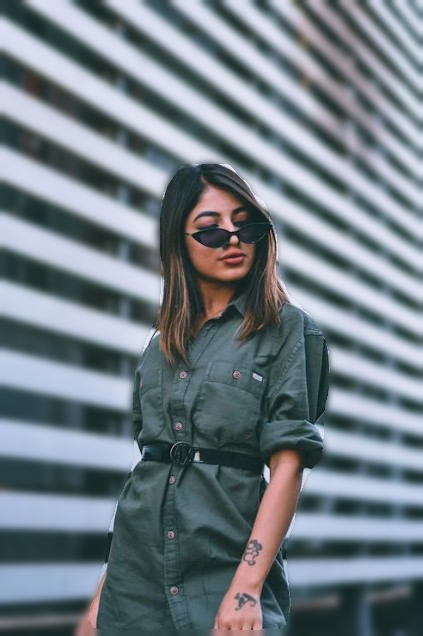

In [22]:
# Convert mask to binary image
_, binary_mask = cv2.threshold(np.array(mask), 128, 255, cv2.THRESH_BINARY)

# Invert binary mask
inverted_mask = binary_mask

mask_inv = cv2.bitwise_not(binary_mask)

# Apply the mask to the image
masked_image = cv2.bitwise_and(blurred_image, blurred_image, mask=mask_inv)

show_image(np.array(masked_image))

# Merge blurred background and foreground
result = cv2.bitwise_or(img, img, mask=inverted_mask)

show_image(np.array(result))

blended_image = cv2.bitwise_or(np.array(result), masked_image)

show_image(np.array(blended_image))